In [1]:
%pip install tqdm scikit-learn numpy python-dateutil flask pandas matplotlib

Note: you may need to restart the kernel to use updated packages.


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from tqdm import tqdm

# Raport z budowy modeli

## Porównanie wytrenowanych modeli
### Model podstawowy - Regresja logistyczna
Training data
Accuracy: 0.8035555555555556
ROC AUC: 0.7792473694710045
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.90      0.85      1343
           1       0.82      0.65      0.73       907

    accuracy                           0.80      2250
   macro avg       0.81      0.78      0.79      2250
weighted avg       0.81      0.80      0.80      2250

Validation data
Accuracy: 0.8044444444444444
ROC AUC: 0.7872229674267754
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.94      0.84       251
           1       0.89      0.64      0.74       199

    accuracy                           0.80       450
   macro avg       0.83      0.79      0.79       450
weighted avg       0.82      0.80      0.80       450


### Model zaawansowany - Random Forest (100 estymatorów)
Random Forest Results:
Training data
Accuracy: 1.0
ROC AUC: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1343
           1       1.00      1.00      1.00       907

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250

Validation data
Accuracy: 0.8355555555555556
ROC AUC: 0.8229193777653206
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       251
           1       0.89      0.71      0.79       199

    accuracy                           0.84       450
   macro avg       0.85      0.82      0.83       450
weighted avg       0.84      0.84      0.83       450

## Dobór hiperparametrów modelu zaawansowanego

In [16]:
def load_data(base_path='data/'):
    X_train = pd.read_csv(f'{base_path}X_train.csv')
    X_val = pd.read_csv(f'{base_path}X_val.csv')
    Y_train = pd.read_csv(f'{base_path}Y_train.csv')
    Y_val = pd.read_csv(f'{base_path}Y_val.csv')
    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = load_data()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

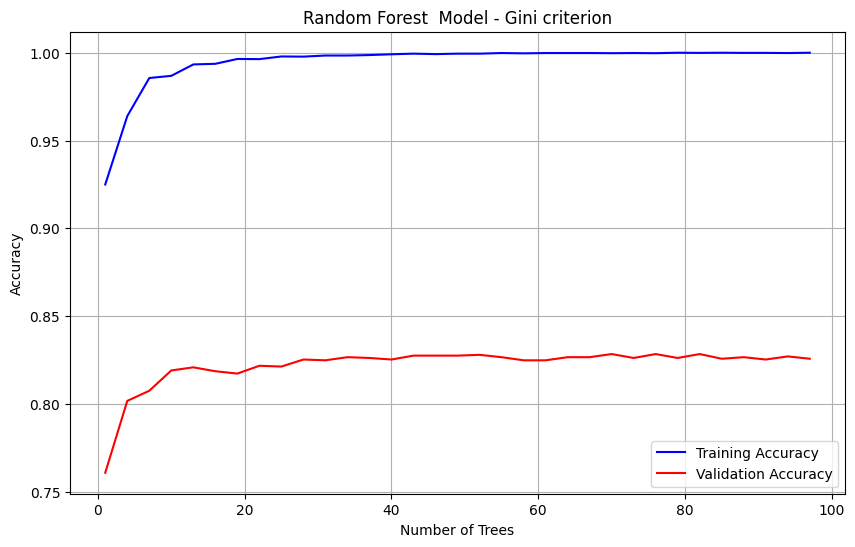

In [ ]:
n_estimators_range = [*range(1,100)]
number_to_sample = 10
criterions = ["gini", "entropy", "log_loss"]

for criterion in criterions:
    train_scores = []
    val_scores = []
    for n_estimators in tqdm(n_estimators_range,leave=False):
        train_score = []
        val_score = []
        for i in range(number_to_sample):
            rf_model = RandomForestClassifier(criterion=criterion,n_estimators=n_estimators, random_state=i+30)
            rf_model.fit(X_train_scaled, Y_train.values.ravel())

            train_pred = rf_model.predict(X_train_scaled)
            val_pred = rf_model.predict(X_val_scaled)
            train_score.append(accuracy_score(Y_train, train_pred))
            val_score.append(accuracy_score(Y_val, val_pred))

        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_scores, '-', label='Training Accuracy', color='blue')
    plt.plot(n_estimators_range, val_scores, '-', label='Validation Accuracy', color='red')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy')
    plt.title(f'Random Forest  Model - {criterion} criterion')
    plt.grid(True)
    plt.legend()
    plt.show()
